In [33]:
!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install gymnasium[other]
!pip install IPython

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [15]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video_html():
  mp4list = glob.glob('videos/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video).decode('ascii')
    ipythondisplay.display(HTML(data='<video controls src="data:video/x-m4v;base64,{0}">'.format(encoded)))
  else:
    print("Could not find video")

In [8]:
class Agent:

    def __init__(self):
        self.cumulative_reward = 0

    def step(self, action_space, observation):
        pass

    def reward(self, immediate_reward, prev_action, prev_observation, new_observation):
        self.cumulative_reward += immediate_reward

    def reset(self):
        print("Cumulative reward for this round:", self.cumulative_reward)
        self.cumulative_reward = 0


def run_episode(env, agent: Agent, show_video=False):
    observation, info = env.reset()
    cumulative_reward = 0
    while True:
        action = agent.step(env.action_space, observation)
        new_observation, reward, terminated, truncated, info  = env.step(action)
        if terminated:
            reward = -1
        agent.reward(reward, action, observation, new_observation)
        observation = new_observation
        if terminated or truncated:
            observation, info = env.reset()
            cumulative_reward += agent.cumulative_reward
            agent.reset()
            break
    if show_video:
        show_video_html()
    return cumulative_reward


In [17]:
import matplotlib.pyplot as plt

class RandomAgent(Agent):
    def step(self, action_space, observation):
        return action_space.sample()

episode_results = []
env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos")
random_agent = RandomAgent()
for i in range(100):
    episode_results.append(run_episode(env, random_agent))



/Users/hx/miniforge3/envs/SC3000/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/Users/hx/miniforge3/envs/SC3000/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/hx/Documents/SC3000/SC3000/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Cumulative reward for this round: 12.0
Cumulative reward for this round: 19.0
Cumulative reward for this round: 14.0
Cumulative reward for this round: 29.0
Cumulative reward for this round: 32.0
Cumulative reward for this round: 28.0
Cumulative reward for this round: 33.0
Cumulative reward for this round: 21.0
Cumulative reward for this round: 17.0
Cumulative reward for this round: 13.0
Cumulative reward for this round: 47.0
Cumulative reward for this round: 16.0
Cumulative reward for this round: 19.0
Cumulative reward for this round: 11.0
Cumulative reward for this round: 13.0
Cumulative reward for this round: 26.0
Cumulative reward for this round: 10.0
Cumulative reward for this round: 41.0
Cumulative reward for this round: 14.0
Cumulative reward for this round: 26.0
Cumulative reward for this round: 22.0
Cumulative reward for this round: 17.0
Cumulative reward for this round: 10.0
Cumulative reward for this round: 10.0
Cumulative reward for this round: 19.0
Cumulative reward for thi

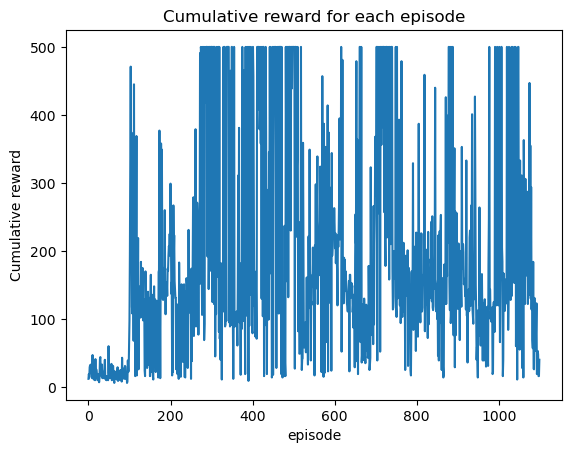

In [19]:
def show_result(episode_results):
    plt.plot(episode_results)
    plt.title('Cumulative reward for each episode')
    plt.ylabel('Cumulative reward')
    plt.xlabel('episode')
    plt.show()

show_result(episode_results)


In [96]:
import numpy as np

# Model free
class QLearningControlAgent(Agent):

    def __init__(self,
        lower_bounds,
        upper_bounds,
        num_bins,
        num_action,
        min_epsilon=0.001, discount_factor=0.9, min_lr=0.1, decay=20,
    ):
        super().__init__()
        self.discount_factor = discount_factor
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.t = 0
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.num_bins = np.array(num_bins)
        self.qtable = np.zeros(np.append(self.num_bins + 1, num_action))

    def to_discrete_state(self, observation):
        bin_window = (self.upper_bounds - self.lower_bounds) / self.num_bins
        clamped_observation = np.clip(observation, self.lower_bounds, self.upper_bounds)
        discrete_state = np.floor((clamped_observation - self.lower_bounds) / bin_window).astype(np.int32)
        return tuple(discrete_state)

    def get_learning_rate(self):
        return max(self.min_lr, min(1., 1. - np.log10((self.t + 1) / self.decay)))

    def get_epsilon(self):
        return max(self.min_epsilon, min(1., 1. - np.log10((self.t + 1) / self.decay)))

    def step(self, action_space, observation):
        state = self.to_discrete_state(observation)
        # Epsilon-greedy policy
        if np.random.random() < self.get_epsilon():
            action = np.random.randint(0, action_space.n)  # Random action
        else:
            action = np.argmax(self.qtable[state])  # Greedy action
        return action

    def reward(self, immediate_reward, prev_action, prev_observation, new_observation):
        super().reward(immediate_reward, prev_action, prev_observation, new_observation)
        prev_state = self.to_discrete_state(prev_observation)
        new_state = self.to_discrete_state(new_observation)
        self.qtable[prev_state + (prev_action,)] += self.get_learning_rate() * (immediate_reward + self.discount_factor * np.max(self.qtable[new_state]) - self.qtable[prev_state + (prev_action,)])

    def reset(self):
        super().reset()
        self.t += 1

episode_results = []
env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos")
upper_bounds = np.array([env.observation_space.high[0], 0.5, env.observation_space.high[2], np.radians(50) / 1.])
lower_bounds = np.array([env.observation_space.low[0], -0.5, env.observation_space.low[2], - np.radians(50) / 1.])
qlearning_agent = QLearningControlAgent(lower_bounds, upper_bounds, [3, 3, 6, 6], env.action_space.n)
for i in range(1000):
    print("Round: " + str(i))
    episode_results.append(run_episode(env, qlearning_agent))

show_result(episode_results)

NameError: name 'Agent' is not defined

In [11]:
from gymnasium.wrappers import RecordVideo
import gymnasium as gym

env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos")
env

/Users/hx/miniforge3/envs/SC3000/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/hx/Documents/SC3000/SC3000/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


<RecordVideo<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>>

<H4> Imports for creating a Deep Q learning agent

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
from collections import deque

<H4> Here we build the neural network using 64 neurons on each layer. The first 2 are hidden layers and last one is the output layer

In [4]:
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

<H4> Here we create the Deep Q learning agent which inherits from Agent class above

In [14]:
class DeepQLearningAgent(Agent):
    # here we initialise our agent
    # state & action size is number of state and possible actions respectively
    # min epsilon is the min value of epsilon for exploration
    # the discount factor determine how future reward are considered
    # min lr is the learning rate when we train the network
    # decay is where set how fast the epsilon decay over time
    def __init__(self, state_size, action_size, min_epsilon=0.01, discount_factor=0.95, min_lr=0.0005, decay=100):
        super().__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = discount_factor
        self.min_epsilon = min_epsilon
        self.min_lr = min_lr
        self.decay = decay
        self.t = 0
        self.epsilon = 1.0

        # here the agent keeps the previous experience
        self.memory = deque(maxlen=10000)
        self.batch_size = 16

        # the Q network will learn and update frequently from experience
        # while the target network will only update after a certain number of episodes
        self.q_network = DQNetwork(state_size, action_size)
        self.target_network = DQNetwork(state_size, action_size)
        self.update_target_network()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.min_lr)
        self.loss_fn = nn.MSELoss()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def get_epsilon(self):
        self.epsilon = max(self.min_epsilon, min(1., 1. - np.log10((self.t + 1) / self.decay)))
        return self.epsilon

    # here the agent either explore by choosing a random action
    # or exploit by choosing an action which give the highest Q value from the neural network
    def step(self, action_space, observation):
        self.get_epsilon()
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.action_size)
        else:
            with torch.no_grad():
                observation = torch.FloatTensor(observation).unsqueeze(0)
                q_values = self.q_network(observation)
                return torch.argmax(q_values).item()

    def reward(self, immediate_reward, prev_action, prev_observation, new_observation):
        super().reward(immediate_reward, prev_action, prev_observation, new_observation)
        self.memory.append((prev_observation, prev_action, immediate_reward, new_observation))
        if len(self.memory) >= 1000:
            self.replay_experience()

    def replay_experience(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        current_q = self.q_network(states).gather(1, actions).squeeze()

        with torch.no_grad():
            next_q_values = self.q_network(next_states)
            next_actions = torch.argmax(next_q_values, dim=1, keepdim=True)
            max_next_q = self.target_network(next_states).gather(1, next_actions).squeeze()

        target_q = rewards + (self.discount_factor * max_next_q)

        loss = self.loss_fn(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def reset(self):
        super().reset()
        self.t += 1
        if self.t % 10 == 0:  # Update target network every 10 episodes
            self.update_target_network()

    # here we can save the model we just trained
    def save_model(self, file_path="models/deep_q_learning_agent.pth"):
        os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Create directory if it doesn't exist
        torch.save(self.q_network.state_dict(), file_path)
        print(f"Model saved to {file_path}")

    # here we can load the saved model for evaluation
    def load_model(self, file_path="models/deep_q_learning_agent.pth"):
        if os.path.exists(file_path):
            self.q_network.load_state_dict(torch.load(file_path))
            self.update_target_network()  # Ensure target network is also updated
            print(f"Model loaded from {file_path}")
        else:
            print(f"Model file '{file_path}' does not exist.")

    # set the agent to go for exploitation only without exploration
    def set_evaluation_mode(self):
        self.epsilon = 0.0

<H4> Here we initialise the environement and the Deep Q learning agent

In [23]:
episode_results = []
env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
deep_q_learning_agent = DeepQLearningAgent(state_size, action_size)

<H4> Here we train the agent, we will train the agent for 2000 episode and saving the model at the end

Cumulative reward for this round: 16.0
Episode 1: Cumulative Reward = 16.0
Cumulative reward for this round: 17.0
Episode 2: Cumulative Reward = 17.0
Cumulative reward for this round: 18.0
Episode 3: Cumulative Reward = 18.0
Cumulative reward for this round: 16.0
Episode 4: Cumulative Reward = 16.0
Cumulative reward for this round: 43.0
Episode 5: Cumulative Reward = 43.0
Cumulative reward for this round: 35.0
Episode 6: Cumulative Reward = 35.0
Cumulative reward for this round: 15.0
Episode 7: Cumulative Reward = 15.0
Cumulative reward for this round: 8.0
Episode 8: Cumulative Reward = 8.0
Cumulative reward for this round: 16.0
Episode 9: Cumulative Reward = 16.0
Cumulative reward for this round: 9.0
Episode 10: Cumulative Reward = 9.0
Cumulative reward for this round: 11.0
Episode 11: Cumulative Reward = 11.0
Cumulative reward for this round: 12.0
Episode 12: Cumulative Reward = 12.0
Cumulative reward for this round: 28.0
Episode 13: Cumulative Reward = 28.0
Cumulative reward for thi

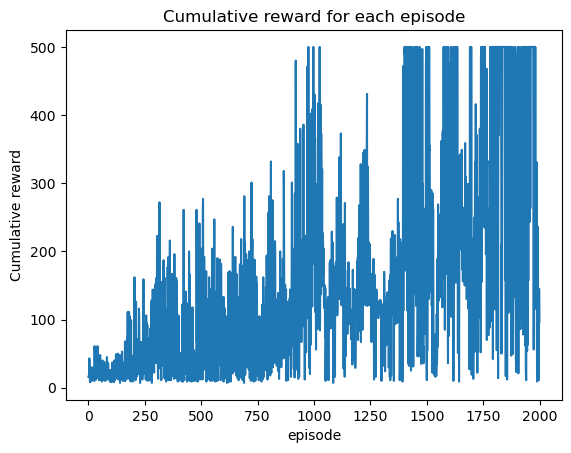

Model saved to models/deep_q_learning_agent1.pth


In [24]:
for i in range(2000):  # Number of episodes
    cumulative_reward = run_episode(env, deep_q_learning_agent)
    episode_results.append(cumulative_reward)

    # Display reward for the current episode
    print(f"Episode {i+1}: Cumulative Reward = {cumulative_reward}")

show_result(episode_results)

deep_q_learning_agent.save_model("models/deep_q_learning_agent1.pth")


<H4> Here we load the previously saved model, and set the Deep Q learning agent to exploitation mode only for evaluation

Model loaded from models/deep_q_learning_agent.pth
Cumulative reward for this round: 35.0
Evaluation Episode 1: Reward = 35.0
Cumulative reward for this round: 201.0
Evaluation Episode 2: Reward = 201.0
Cumulative reward for this round: 10.0
Evaluation Episode 3: Reward = 10.0
Cumulative reward for this round: 500.0
Evaluation Episode 4: Reward = 500.0
Cumulative reward for this round: 191.0
Evaluation Episode 5: Reward = 191.0
Cumulative reward for this round: 50.0
Evaluation Episode 6: Reward = 50.0
Cumulative reward for this round: 158.0
Evaluation Episode 7: Reward = 158.0
Cumulative reward for this round: 176.0
Evaluation Episode 8: Reward = 176.0
Cumulative reward for this round: 163.0
Evaluation Episode 9: Reward = 163.0
Cumulative reward for this round: 170.0
Evaluation Episode 10: Reward = 170.0
Cumulative reward for this round: 122.0
Evaluation Episode 11: Reward = 122.0
Cumulative reward for this round: 69.0
Evaluation Episode 12: Reward = 69.0
Cumulative reward for this rou

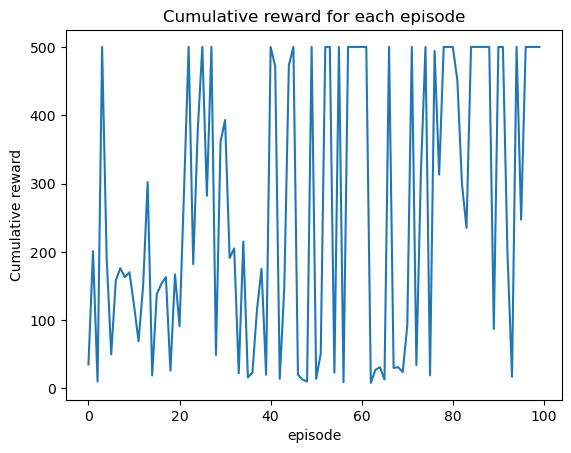

In [26]:
deep_q_learning_agent.load_model("models/deep_q_learning_agent.pth")
deep_q_learning_agent.set_evaluation_mode()

evaluation_results = []
for i in range(100):
    cumulative_reward = run_episode(env, deep_q_learning_agent)
    evaluation_results.append(cumulative_reward)
    print(f"Evaluation Episode {i+1}: Reward = {cumulative_reward}")

show_result(evaluation_results)